Deep Learning Project 1 - notMNIST

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
from time import time

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

First, the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labeled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [2]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '.' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified .\notMNIST_large.tar.gz
Found and verified .\notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file. This should give you a set of directories, labeled A through J.

In [3]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

.\notMNIST_large already present - Skipping extraction of .\notMNIST_large.tar.gz.
['.\\notMNIST_large\\A', '.\\notMNIST_large\\B', '.\\notMNIST_large\\C', '.\\notMNIST_large\\D', '.\\notMNIST_large\\E', '.\\notMNIST_large\\F', '.\\notMNIST_large\\G', '.\\notMNIST_large\\H', '.\\notMNIST_large\\I', '.\\notMNIST_large\\J']
.\notMNIST_small already present - Skipping extraction of .\notMNIST_small.tar.gz.
['.\\notMNIST_small\\A', '.\\notMNIST_small\\B', '.\\notMNIST_small\\C', '.\\notMNIST_small\\D', '.\\notMNIST_small\\E', '.\\notMNIST_small\\F', '.\\notMNIST_small\\G', '.\\notMNIST_small\\H', '.\\notMNIST_small\\I', '.\\notMNIST_small\\J']


Problem 1
Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

In [4]:
#loop for number of training folders to sample
folder_samples = 2
for i in range(0,folder_samples):
    #Assign folder path name from training folder list
    path_name_str = train_folders[i]
    #Define the sample images quality from each folder to display
    image_samples = 2
    #Define directory list in the training folder
    file_name_list = os.listdir(path_name_str)
    #loop to display the sample images...must start at one(1)
    for j in range(1,(image_samples+1)):
        #Define file name string from list
        file_name_str = file_name_list[j]
        #Print the image path and file name
        print(path_name_str, file_name_str)
        #Display images from path name and file name string concatenation
        display(Image(path_name_str+'\\'+file_name_str))



.\notMNIST_large\A a2F6b28udHRm.png


.\notMNIST_large\A a2FkZW4udHRm.png


.\notMNIST_large\B a2F6b28udHRm.png


.\notMNIST_large\B a2FkZW4udHRm.png


In [5]:
#Define number of folders to sample
folder_samples = 2
#loop for number of test folders to sample
for i in range(0,folder_samples):
    #Assign folder path name from test folder list
    path_name_str = test_folders[i]
    #Define the sample images quality from each folder to display
    image_samples = 2
    #Define directory list in the training folder
    file_name_list = os.listdir(path_name_str)
    #loop to display the sample images...must start at one(1)
    for j in range(1,(image_samples+1)):
        #Define file name string from list
        file_name_str = file_name_list[j]
        #Print the image path and file name
        print(path_name_str, file_name_str)
        #Display images from path name and file name string concatenation
        display(Image(path_name_str+'\\'+file_name_str))



.\notMNIST_small\A MDRiXzA4LnR0Zg==.png


.\notMNIST_small\A MjAwcHJvb2Ztb29uc2hpbmUgcmVtaXgudHRm.png


.\notMNIST_small\B MDRiXzA4LnR0Zg==.png


.\notMNIST_small\B MjAwcHJvb2Ztb29uc2hpbmUgcmVtaXgudHRm.png


Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size. We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. A few images might not be readable, we'll just skip them.

In [4]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  #Establish dataset np.array dimensions
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

.\notMNIST_large\A.pickle already present - Skipping pickling.
.\notMNIST_large\B.pickle already present - Skipping pickling.
.\notMNIST_large\C.pickle already present - Skipping pickling.
.\notMNIST_large\D.pickle already present - Skipping pickling.
.\notMNIST_large\E.pickle already present - Skipping pickling.
.\notMNIST_large\F.pickle already present - Skipping pickling.
.\notMNIST_large\G.pickle already present - Skipping pickling.
.\notMNIST_large\H.pickle already present - Skipping pickling.
.\notMNIST_large\I.pickle already present - Skipping pickling.
.\notMNIST_large\J.pickle already present - Skipping pickling.
.\notMNIST_small\A.pickle already present - Skipping pickling.
.\notMNIST_small\B.pickle already present - Skipping pickling.
.\notMNIST_small\C.pickle already present - Skipping pickling.
.\notMNIST_small\D.pickle already present - Skipping pickling.
.\notMNIST_small\E.pickle already present - Skipping pickling.
.\notMNIST_small\F.pickle already present - Skipping pi

Verifying that the data still looks good. Displaying a sample of the labels and images from the ndarray using matplotlib.pyplot.

Training Dataset Name .\notMNIST_large\H.pickle with Image Label 0
Training Dataset Name .\notMNIST_large\H.pickle with Image Label 1
Training Dataset Name .\notMNIST_large\I.pickle with Image Label 0
Training Dataset Name .\notMNIST_large\I.pickle with Image Label 1


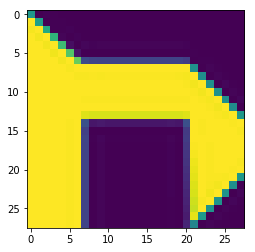

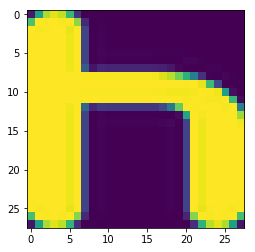

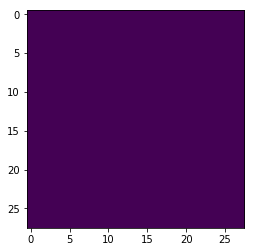

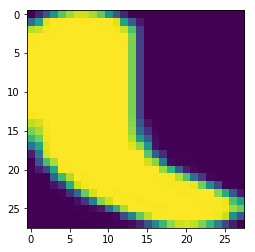

In [7]:
#Define number of datasets to sample
dataset_samples = 2
#loop for number of training datasets to sample
for i in range(7,9):
    #Open pickle file to 'rb' read instruction 
    pickle_image_file = open(train_datasets[i],'rb')
    #Recover 3D nparray of image
    normalized_3D_image_nparray = pickle.load(pickle_image_file)
    #Define the sample images quality from each folder to display
    image_samples = 2
    #loop to display the sample image
    for j in range(0,image_samples):
        #Convert 3D nparray to 2D nparray for displaying images
        normalized_2D_image_nparray =  normalized_3D_image_nparray[j,0:28,0:28]
        #Display dataset name, image label and plot image file
        print('Training Dataset Name {} with Image Label {}'.format(train_datasets[i],j))
        plt.figure()
        plt.imshow(normalized_2D_image_nparray)



Test Dataset Name .\notMNIST_small\H.pickle with Image Label 0
Test Dataset Name .\notMNIST_small\H.pickle with Image Label 1
Test Dataset Name .\notMNIST_small\I.pickle with Image Label 0
Test Dataset Name .\notMNIST_small\I.pickle with Image Label 1


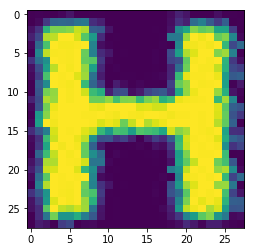

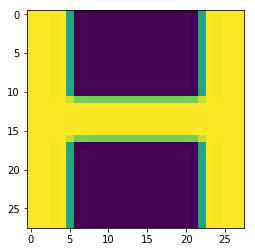

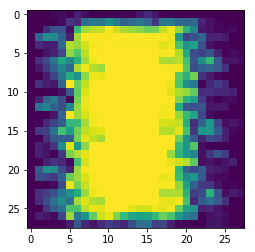

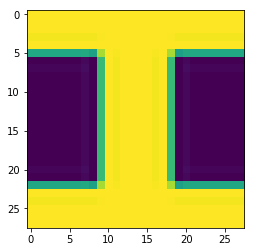

In [8]:
#Define number of datasets to sample
dataset_samples = 2
#loop for number of training datasets to sample
for i in range(7,9):
    #Open pickle file to 'rb' read instruction
    pickle_image_file = open(test_datasets[i],'rb')
    #Recover 3D nparray of image
    normalized_3D_image_nparray = pickle.load(pickle_image_file)
    #Define the sample images quality from each folder to display
    image_samples = 2
    #loop to display the sample image
    for j in range(0,image_samples):
        #Convert 3D nparray to 2D nparray for displaying images
        normalized_2D_image_nparray =  normalized_3D_image_nparray[j,0:28,0:28]
        #Display dataset name, image label and plot image file
        print('Test Dataset Name {} with Image Label {}'.format(test_datasets[i],j))
        plt.figure()
        plt.imshow(normalized_2D_image_nparray)

Verify data are balanced across classes with training and test datasets bar charts

([<matplotlib.axis.XTick at 0x1b9bfb81518>,
 <a list of 10 Text xticklabel objects>)

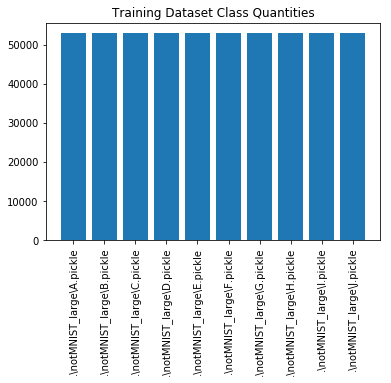

In [7]:
#Establish dataset to visualize
datesets=[]
datasets = train_datasets
#Establish a list for the number of images in each training dataset class
dataset_image_num_list = []
#loop for each class in the training dataset
for i in range(len(datasets)):
    #Open pickle file to 'rb' read instruction
    pickle_image_file = open(datasets[i],'rb')
    #Recover 3D nparray of image
    normalized_3D_image_nparray = pickle.load(pickle_image_file)
    class_dataset_shape = normalized_3D_image_nparray.shape
    dataset_image_num = class_dataset_shape[0]
    #update list with the number of images in the class
    dataset_image_num_list.append(dataset_image_num)
    
plt.bar(range(len(datasets)),dataset_image_num_list, align='center')
plt.title('Training Dataset Class Quantities')
plt.xticks(range(len(datasets)),datasets,rotation='vertical')
    

([<matplotlib.axis.XTick at 0x1b9a64db860>,
 <a list of 10 Text xticklabel objects>)

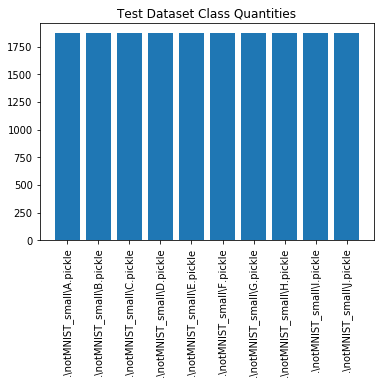

In [8]:
#Establish dataset to visualize
datesets=[]
datasets = test_datasets
#Establish a list for the number of images in each test dataset class
dataset_image_num_list = []
#loop for each class in the training dataset
for i in range(len(datasets)):
    #Open pickle file to 'rb' read instruction
    pickle_image_file = open(datasets[i],'rb')
    #Recover 3D nparray of image
    normalized_3D_image_nparray = pickle.load(pickle_image_file)
    class_dataset_shape = normalized_3D_image_nparray.shape
    dataset_image_num = class_dataset_shape[0]
    #update list with the number of images in the class
    dataset_image_num_list.append(dataset_image_num)
    
plt.bar(range(len(datasets)),dataset_image_num_list, align='center')
plt.title('Test Dataset Class Quantities')
plt.xticks(range(len(datasets)),datasets,rotation='vertical')

Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune train_size as needed. The labels will be stored into a separate array of integers 0 through 9.
Also create a validation dataset for hyperparameter tuning.

In [5]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  #Define nparray dimensions for datasets
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  #floor division for whole number quotient
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          #Splice top images from nparray per valid class size
          valid_letter = letter_set[:vsize_per_class, :, :]
          #Update valid dataset nparray with spliced image values 
          valid_dataset[start_v:end_v, :, :] = valid_letter
          #Update valid label nparray with spliced image labels
          valid_labels[start_v:end_v] = label
          #Increment start and end indices by valid class sizes
          start_v += vsize_per_class
          end_v += vsize_per_class
        #Splice next images from nparray per training class size           
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        #Update training dataset nparray with spliced image values
        train_dataset[start_t:end_t, :, :] = train_letter
        #Update training label nparray with spliced image labels
        train_labels[start_t:end_t] = label
        #Increment start and end indices by training class sizes
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


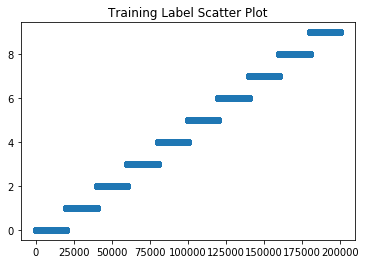

In [10]:
plt.title('Training Label Scatter Plot')
plt.plot(np.arange(1,(len(train_labels)+1)),train_labels,"o")

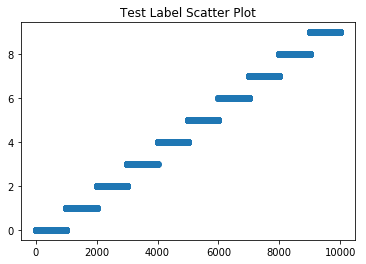

In [11]:
plt.title('Test Label Scatter Plot')
plt.plot(np.arange(1,(len(test_labels)+1)),test_labels,"o")

In [6]:

#Compare Zero(A) classes between training and test datasets
training_index_list_A = []
duplicate_count_A = 0
start = time()
for i in range(0,20000):
    for j in range(0,1000):
        if (np.array_equal(train_dataset[i,0:28,0:28],test_dataset[j,0:28,0:28])):
            training_index_list_A.append(i)
            duplicate_count_A +=1
end = time()
print('Completed in {:.4f} hours'.format((end-start)/3600.0))
print('{} Duplicate A Images'.format(duplicate_count_A))

    
    

Completed in 0.0291 hours
125 Duplicate A Images


In [46]:
print('A Duplicate Index Test List',test_index_list_A)

A Duplicate Index Test List [430, 144, 129, 388, 360, 918, 549, 546, 98, 865, 15, 411, 802, 457, 584, 509, 128, 669, 975, 141, 719, 832, 254, 475, 215, 293, 584, 345, 674, 609, 585, 845, 457, 424, 970, 287, 773, 464, 374, 394, 429, 334, 375, 55, 388, 525, 929, 469, 785, 516, 970, 0, 53, 146, 766, 952, 80, 290, 241, 227, 226, 967, 388, 147, 785, 922, 10, 146, 244, 635, 668, 245, 214, 500, 159, 0, 727, 52, 724, 460, 418, 614, 28, 270, 660, 8, 0, 245, 284, 833, 584, 838, 247, 256, 368, 388, 207, 651, 984, 773, 52, 127, 404, 631, 175, 782, 726, 779, 620, 623, 682, 353, 545, 929, 3, 742, 623, 57, 902, 298, 975, 917, 569, 969, 652]


[With for in loop break] Completed in 0.2435 hours
120 Duplicate A Images

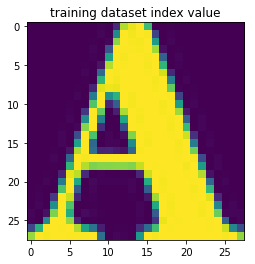

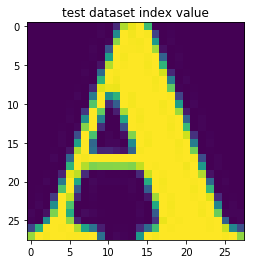

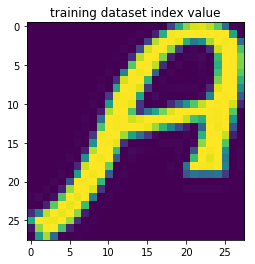

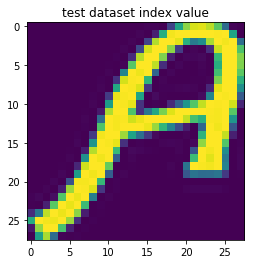

In [51]:
image_samples = 2
for j in range(0,image_samples):
    #Display dataset name, image label and plot image file
    plt.figure()
    plt.title('training dataset index value')
    plt.imshow(train_dataset[training_index_list_A[j],0:28,0:28])
    plt.figure()
    plt.title('test dataset index value')
    plt.imshow(test_dataset[test_index_list_A[j],0:28,0:28])

In [7]:
"""
Delete duplicate image between training and test datasets in new sanitized class A dataset with np.delete
"""
print('A Class Training Duplication Index List',training_index_list_A)

# Define temporary  dataset and labels np arrays for image class to address np.delete max index limitation
array_size = 20000
start_splice = 0
end_splice = 20000
temp_dataset = np.ndarray((array_size, 28, 28), dtype=np.float32)
temp_dataset = train_dataset[start_splice:end_splice,0:28,0:28]
temp_labels = np.ndarray(array_size, dtype=np.int32)
temp_labels= train_labels[start_splice:end_splice,]

# Define offset index list of image class duplicates
offset_training_index_list = []
index_offset =0

if (index_offset != 0):
    #Loop for index to offset
    for i in range(0,len(training_index_list_A)):
        offset_training_index_list.append(training_index_list_A[i]-index_offset)
else:
    for i in range(0,len(training_index_list_A)):
        offset_training_index_list.append(training_index_list_A[i])
            
print('Offset Index',offset_training_index_list)

start = time()
# Create new sanitized class dataset without duplicate images
sanitized_A_dataset = np.delete(temp_dataset[0:array_size,0:28,0:28],offset_training_index_list,0)
# Create new sanitized label array
sanitized_A_labels = np.delete(temp_labels[0:array_size,],offset_training_index_list,0)
end = time()       

print('Completed in {:.4f} hours'.format((end-start)/3600.0))
print('Sanitized A Dataset:', sanitized_A_dataset.shape, sanitized_A_labels.shape)


A Class Training Duplication Index List [285, 344, 363, 381, 420, 555, 1274, 1283, 1299, 1405, 1555, 2604, 2738, 3326, 3643, 3720, 3861, 4005, 4089, 4483, 4537, 5016, 5067, 5297, 5310, 5580, 5636, 5767, 5837, 5878, 5889, 6182, 6362, 6367, 6901, 6970, 7006, 7142, 7603, 7798, 7934, 8117, 8705, 8766, 8913, 8930, 8983, 9001, 9044, 9055, 9546, 9655, 9676, 9764, 9838, 9851, 10467, 10532, 10742, 11085, 11216, 11342, 11390, 11465, 11658, 11883, 12002, 12055, 12139, 12313, 12523, 12573, 12637, 12744, 12986, 13008, 13027, 13043, 13091, 13321, 13328, 13737, 13815, 13815, 13879, 14839, 14874, 15058, 15169, 15410, 15416, 15666, 15995, 16186, 16354, 16838, 16880, 16880, 17000, 17471, 17532, 17555, 17667, 17667, 17683, 17721, 17815, 17815, 17903, 18111, 18329, 18470, 18514, 18743, 19077, 19077, 19483, 19538, 19540, 19552, 19577, 19628, 19682, 19690, 19945]
Offset Index [285, 344, 363, 381, 420, 555, 1274, 1283, 1299, 1405, 1555, 2604, 2738, 3326, 3643, 3720, 3861, 4005, 4089, 4483, 4537, 5016, 5067, 

In [8]:

#Compare Zero(A) classes between sanitized training and valid datasets for validation
sanitized_second_index_list_A = []
sanitized_second_duplicate_count_A = 0
array_range = sanitized_A_dataset.shape[0]
start = time()
for i in range(0,array_range):
    for j in range(0,1000):
        if (np.array_equal(sanitized_A_dataset[i,0:28,0:28],valid_dataset[j,0:28,0:28])):
            sanitized_second_index_list_A.append(i)
            sanitized_second_duplicate_count_A +=1
end = time()
print('Completed in {:.4f} hours'.format((end-start)/3600.0))
print('{} Duplicate A Images with Valid Dataset'.format(sanitized_second_duplicate_count_A))
print('Second Sanitized A Duplicate Index List',sanitized_second_index_list_A)

    
    

Completed in 0.0289 hours
87 Duplicate A Images with Valid Dataset
Second Sanitized A Duplicate Index List [372, 516, 767, 768, 793, 798, 1001, 1163, 1204, 1300, 1367, 1775, 1784, 1975, 2651, 2828, 2855, 3047, 3353, 3609, 3632, 3853, 4048, 4116, 4142, 4901, 4918, 5154, 5277, 5666, 6367, 6599, 6688, 6872, 6970, 7384, 7462, 7909, 7933, 8583, 8790, 9103, 9117, 9471, 9650, 9942, 10036, 10217, 10365, 10613, 10635, 10823, 11104, 11413, 11593, 11989, 12073, 12403, 12799, 12805, 12911, 13063, 13193, 13695, 14166, 14514, 14858, 15038, 15051, 15228, 15470, 15971, 16106, 16143, 16251, 16594, 16699, 17023, 17625, 17955, 18261, 18608, 18632, 18779, 18897, 19091, 19445]


In [9]:
"""
Delete duplicate image between the sanitized training and valid datasets in a new sanitized class A dataset with np.delete
"""
print('Second Sanitized A Duplicate Index List',sanitized_second_index_list_A)
first_dataset_size = sanitized_A_dataset.shape[0]
start = time()
# Create new sanitized class dataset without duplicate images
sanitized_second_A_dataset = np.delete(sanitized_A_dataset[0:first_dataset_size,0:28,0:28],sanitized_second_index_list_A,0)
# Create new sanitized label array
sanitized_second_A_labels = np.delete(sanitized_A_labels[0:first_dataset_size,],sanitized_second_index_list_A,0)
end = time()       

print('Completed in {:.4f} hours'.format((end-start)/3600.0))
print('Sanitized A Dataset:', sanitized_second_A_dataset.shape, sanitized_second_A_labels.shape)


Second Sanitized A Duplicate Index List [372, 516, 767, 768, 793, 798, 1001, 1163, 1204, 1300, 1367, 1775, 1784, 1975, 2651, 2828, 2855, 3047, 3353, 3609, 3632, 3853, 4048, 4116, 4142, 4901, 4918, 5154, 5277, 5666, 6367, 6599, 6688, 6872, 6970, 7384, 7462, 7909, 7933, 8583, 8790, 9103, 9117, 9471, 9650, 9942, 10036, 10217, 10365, 10613, 10635, 10823, 11104, 11413, 11593, 11989, 12073, 12403, 12799, 12805, 12911, 13063, 13193, 13695, 14166, 14514, 14858, 15038, 15051, 15228, 15470, 15971, 16106, 16143, 16251, 16594, 16699, 17023, 17625, 17955, 18261, 18608, 18632, 18779, 18897, 19091, 19445]
Completed in 0.0000 hours
Sanitized A Dataset: (19793, 28, 28) (19793,)


sanitized_second_A_dataset and sanitized_second_A_labels arrays above are fully sanitized training data with test and 
valid datasets

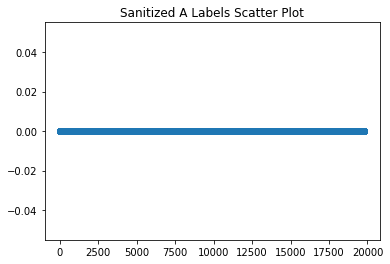

In [10]:
plt.title('Sanitized A Labels Scatter Plot')
plt.plot(np.arange(1,(len(sanitized_second_A_labels)+1)),sanitized_second_A_labels,"o")

In [11]:
#Compare one(B) classes between training and test datasets
training_index_list_B = []
duplicate_count_B = 0
start = time()
for i in range(20000,40000):
    for j in range(1000,2000):
        if (np.array_equal(train_dataset[i,0:28,0:28],test_dataset[j,0:28,0:28])):
            training_index_list_B.append(i)
            duplicate_count_B +=1
            break
end = time()
print('Completed in {:.4f} hours'.format((end-start)/3600.0))
print('{} Duplicate B Images'.format(duplicate_count_B))

    
    

Completed in 0.0292 hours
149 Duplicate B Images


In [12]:
"""
Delete duplicate image between training and test datasets in new sanitized class B dataset with np.delete
"""
print('B Class Training Duplication Index List',training_index_list_B)

# Define temporary  dataset and labels np arrays for image class to address np.delete max index limitation
array_size = 20000
start_splice = 20000
end_splice = 40000
temp_dataset = np.ndarray((array_size, 28, 28), dtype=np.float32)
temp_dataset = train_dataset[start_splice:end_splice,0:28,0:28]
temp_labels = np.ndarray(array_size, dtype=np.int32)
temp_labels= train_labels[start_splice:end_splice,]

# Define offset index list of image class duplicates
offset_training_index_list = []
index_offset = 20000
#Loop for index to offset
for i in range(0,len(training_index_list_B)):
    offset_training_index_list.append(training_index_list_B[i]-index_offset)

    
start = time()
# Create new sanitized class dataset without duplicate images
sanitized_B_dataset = np.delete(temp_dataset[0:array_size,0:28,0:28],offset_training_index_list,0)
# Create new sanitized label array
sanitized_B_labels = np.delete(temp_labels[0:array_size,],offset_training_index_list,0)
end = time()       

print('Completed in {:.4f} hours'.format((end-start)/3600.0))
print('Sanitized B Dataset:', sanitized_B_dataset.shape, sanitized_B_labels.shape)


B Class Training Duplication Index List [20178, 20201, 20396, 20398, 20453, 20484, 20792, 20822, 20974, 21161, 21243, 21260, 21323, 21415, 21572, 21587, 21598, 21713, 21724, 21765, 21847, 21921, 22014, 22041, 22086, 22129, 22165, 22258, 22462, 22499, 22583, 23031, 23080, 23094, 23219, 23253, 23823, 23878, 23948, 24162, 24215, 24232, 24395, 24859, 24930, 24946, 25207, 25261, 25310, 26200, 26262, 26555, 26585, 26586, 26603, 26705, 26916, 27041, 27106, 27307, 27417, 27441, 27497, 27669, 28073, 28173, 28274, 28464, 28484, 28722, 28760, 28776, 28899, 29059, 29084, 29286, 29413, 29622, 29659, 29984, 30212, 30400, 30409, 30453, 30517, 30552, 30565, 30841, 30923, 31105, 31256, 31558, 31667, 31970, 32378, 32582, 32735, 32753, 32761, 33019, 33427, 33451, 33568, 33616, 34009, 34087, 34369, 34416, 34465, 34581, 34710, 35074, 35324, 35446, 35659, 35850, 35899, 35996, 36134, 36388, 36449, 36523, 36594, 36620, 37037, 37173, 37186, 37297, 37343, 37505, 37682, 37866, 37945, 38009, 38074, 38078, 38252, 

In [13]:

#Compare One(B) classes between sanitized training and valid datasets for validation
sanitized_second_index_list_B = []
sanitized_second_duplicate_count_B = 0
array_range = sanitized_B_dataset.shape[0]
start = time()
for i in range(0,array_range):
    for j in range(1000,2000):
        if (np.array_equal(sanitized_B_dataset[i,0:28,0:28],valid_dataset[j,0:28,0:28])):
            sanitized_second_index_list_B.append(i)
            sanitized_second_duplicate_count_B +=1
end = time()
print('Completed in {:.4f} hours'.format((end-start)/3600.0))
print('{} Duplicate B Images with Valid Dataset'.format(sanitized_second_duplicate_count_B))
print('Second Sanitized B Duplicate Index List',sanitized_second_index_list_B)

    
    

Completed in 0.0286 hours
104 Duplicate B Images with Valid Dataset
Second Sanitized B Duplicate Index List [381, 763, 1363, 2397, 2719, 2860, 3137, 3226, 3381, 3795, 4217, 4437, 4614, 4773, 4901, 4946, 5403, 5460, 5667, 5756, 5870, 6282, 6537, 7032, 7037, 7119, 7241, 7261, 7381, 7381, 7526, 7834, 7918, 8200, 8267, 8270, 8448, 8487, 8882, 8973, 9038, 9211, 9267, 9402, 9650, 9790, 9895, 10232, 10248, 10551, 10818, 10868, 11049, 11174, 11400, 12055, 12080, 12166, 12292, 12346, 12540, 12899, 13004, 13180, 13328, 13511, 13584, 13588, 13662, 13902, 14390, 14455, 14667, 15164, 15194, 15443, 15507, 15570, 15624, 15904, 15905, 16017, 16163, 16296, 16354, 16391, 16572, 16920, 17036, 17051, 17273, 17495, 17577, 17962, 18180, 18344, 18880, 19007, 19062, 19100, 19397, 19466, 19571, 19796]


In [14]:
"""
Delete duplicate image between the sanitized training and valid datasets in a new sanitized class B dataset with np.delete
"""
print('Second Sanitized B Duplicate Index List',sanitized_second_index_list_B)
first_dataset_size = sanitized_B_dataset.shape[0]
start = time()
# Create new sanitized class dataset without duplicate images
sanitized_second_B_dataset = np.delete(sanitized_B_dataset[0:first_dataset_size,0:28,0:28],sanitized_second_index_list_B,0)
# Create new sanitized label array
sanitized_second_B_labels = np.delete(sanitized_B_labels[0:first_dataset_size,],sanitized_second_index_list_B,0)
end = time()       

print('Completed in {:.4f} hours'.format((end-start)/3600.0))
print('Sanitized B Dataset:', sanitized_second_B_dataset.shape, sanitized_second_B_labels.shape)


Second Sanitized B Duplicate Index List [381, 763, 1363, 2397, 2719, 2860, 3137, 3226, 3381, 3795, 4217, 4437, 4614, 4773, 4901, 4946, 5403, 5460, 5667, 5756, 5870, 6282, 6537, 7032, 7037, 7119, 7241, 7261, 7381, 7381, 7526, 7834, 7918, 8200, 8267, 8270, 8448, 8487, 8882, 8973, 9038, 9211, 9267, 9402, 9650, 9790, 9895, 10232, 10248, 10551, 10818, 10868, 11049, 11174, 11400, 12055, 12080, 12166, 12292, 12346, 12540, 12899, 13004, 13180, 13328, 13511, 13584, 13588, 13662, 13902, 14390, 14455, 14667, 15164, 15194, 15443, 15507, 15570, 15624, 15904, 15905, 16017, 16163, 16296, 16354, 16391, 16572, 16920, 17036, 17051, 17273, 17495, 17577, 17962, 18180, 18344, 18880, 19007, 19062, 19100, 19397, 19466, 19571, 19796]
Completed in 0.0000 hours
Sanitized B Dataset: (19748, 28, 28) (19748,)


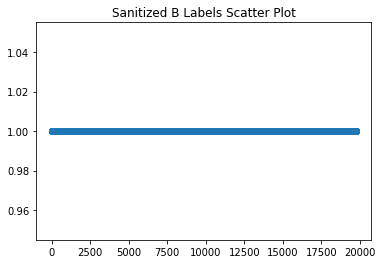

In [15]:
plt.title('Sanitized B Labels Scatter Plot')
plt.plot(np.arange(1,(len(sanitized_second_B_labels)+1)),sanitized_second_B_labels,"o")

In [16]:
#Compare two(C) classes between training and test datasets
training_index_list_C = []
duplicate_count_C = 0
start = time()
for i in range(40000,60000):
    for j in range(2000,3000):
        if (np.array_equal(train_dataset[i,0:28,0:28],test_dataset[j,0:28,0:28])):
            training_index_list_C.append(i)
            duplicate_count_C +=1
end = time()
print('Completed in {:.4f} hours'.format((end-start)/3600.0))
print('{} Duplicate C Images'.format(duplicate_count_C))

    
    

Completed in 0.0288 hours
157 Duplicate C Images


In [17]:
"""
Delete duplicate image between training and test datasets in new sanitized class C dataset with np.delete
"""
print('C Class Training Duplication Index List',training_index_list_C)

# Define temporary  dataset and labels np arrays for image class to address np.delete max index limitation
array_size = 20000
start_splice = 40000
end_splice = 60000
temp_dataset = np.ndarray((array_size, 28, 28), dtype=np.float32)
temp_dataset = train_dataset[start_splice:end_splice,0:28,0:28]
temp_labels = np.ndarray(array_size, dtype=np.int32)
temp_labels= train_labels[start_splice:end_splice,]

# Define offset index list of image class duplicates
offset_training_index_list = []
index_offset = 40000
#Loop for index to offset
for i in range(0,len(training_index_list_C)):
    offset_training_index_list.append(training_index_list_C[i]-index_offset)
start = time()
# Create new sanitized class dataset without duplicate images
sanitized_C_dataset = np.delete(temp_dataset[0:array_size,0:28,0:28],offset_training_index_list,0)
# Create new sanitized label array
sanitized_C_labels = np.delete(temp_labels[0:array_size,],offset_training_index_list,0)
end = time()       

print('Completed in {:.4f} hours'.format((end-start)/3600.0))
print('Sanitized C Dataset:', sanitized_C_dataset.shape, sanitized_C_labels.shape)


C Class Training Duplication Index List [40228, 40263, 40319, 40544, 40613, 40662, 40714, 40871, 40963, 40991, 41045, 41063, 41177, 41205, 41429, 41545, 41599, 41642, 41791, 41939, 42018, 42042, 42068, 42235, 42476, 42562, 42601, 42616, 42656, 42679, 42897, 43021, 43256, 43293, 43451, 43501, 43688, 43699, 44320, 44338, 44519, 44627, 44630, 44901, 44940, 45123, 45181, 45354, 45437, 45600, 45706, 45995, 46102, 46147, 46279, 46694, 46700, 46711, 46737, 46800, 47065, 47323, 47668, 47798, 47883, 48042, 48275, 48570, 48638, 48673, 48828, 48876, 48955, 49084, 49106, 49138, 49310, 49342, 49510, 49525, 49567, 49614, 50032, 50051, 50248, 50350, 50611, 50668, 50978, 51174, 51251, 51409, 51545, 51655, 51725, 51739, 51744, 51805, 52221, 52526, 52527, 52570, 52815, 52840, 52912, 53037, 53086, 53414, 53430, 53730, 53775, 53804, 53842, 53884, 53981, 54216, 54303, 54393, 54564, 54706, 55059, 55110, 55355, 55388, 55665, 55682, 55716, 55744, 55997, 56061, 56555, 56605, 56650, 56743, 56876, 57126, 57285, 

In [18]:

#Compare two(C) classes between sanitized training and valid datasets for validation
sanitized_second_index_list_C = []
sanitized_second_duplicate_count_C = 0
array_range = sanitized_C_dataset.shape[0]
start = time()
for i in range(0,array_range):
    for j in range(2000,3000):
        if (np.array_equal(sanitized_C_dataset[i,0:28,0:28],valid_dataset[j,0:28,0:28])):
            sanitized_second_index_list_C.append(i)
            sanitized_second_duplicate_count_C +=1
            break
end = time()
print('Completed in {:.4f} hours'.format((end-start)/3600.0))
print('{} Duplicate C Images with Valid Dataset'.format(sanitized_second_duplicate_count_C))
print('Second Sanitized C Duplicate Index List',sanitized_second_index_list_C)

    
    

Completed in 0.0288 hours
99 Duplicate C Images with Valid Dataset
Second Sanitized C Duplicate Index List [77, 472, 735, 872, 1259, 1417, 1464, 1815, 2079, 2414, 2512, 2522, 2635, 2892, 2961, 3274, 3331, 3502, 4115, 4266, 4540, 4544, 4709, 4713, 5001, 5059, 5298, 5521, 5816, 5846, 5990, 6046, 6153, 6162, 6796, 7128, 8038, 8055, 8476, 8584, 9237, 9350, 9376, 9505, 9587, 10060, 10171, 10206, 10352, 10589, 10888, 10900, 10915, 10938, 11036, 11223, 11452, 11681, 11874, 11886, 12356, 12593, 12650, 13048, 13089, 13283, 13384, 13674, 14264, 14362, 14393, 14403, 14455, 14581, 14893, 15020, 15492, 15699, 15862, 16045, 16203, 16335, 16725, 16831, 16840, 16981, 17047, 17245, 17869, 18033, 18318, 18660, 18685, 19009, 19370, 19437, 19470, 19588, 19647]


In [20]:
"""
Delete duplicate image between the sanitized training and valid datasets in a new sanitized class C dataset with np.delete
"""
print('Second Sanitized C Duplicate Index List',sanitized_second_index_list_C)
first_dataset_size = sanitized_C_dataset.shape[0]
start = time()
# Create new sanitized class dataset without duplicate images
sanitized_second_C_dataset = np.delete(sanitized_C_dataset[0:first_dataset_size,0:28,0:28],sanitized_second_index_list_C,0)
# Create new sanitized label array
sanitized_second_C_labels = np.delete(sanitized_C_labels[0:first_dataset_size,],sanitized_second_index_list_C,0)
end = time()       

print('Completed in {:.4f} hours'.format((end-start)/3600.0))
print('Sanitized C Dataset:', sanitized_second_C_dataset.shape, sanitized_second_C_labels.shape)


Second Sanitized C Duplicate Index List [77, 472, 735, 872, 1259, 1417, 1464, 1815, 2079, 2414, 2512, 2522, 2635, 2892, 2961, 3274, 3331, 3502, 4115, 4266, 4540, 4544, 4709, 4713, 5001, 5059, 5298, 5521, 5816, 5846, 5990, 6046, 6153, 6162, 6796, 7128, 8038, 8055, 8476, 8584, 9237, 9350, 9376, 9505, 9587, 10060, 10171, 10206, 10352, 10589, 10888, 10900, 10915, 10938, 11036, 11223, 11452, 11681, 11874, 11886, 12356, 12593, 12650, 13048, 13089, 13283, 13384, 13674, 14264, 14362, 14393, 14403, 14455, 14581, 14893, 15020, 15492, 15699, 15862, 16045, 16203, 16335, 16725, 16831, 16840, 16981, 17047, 17245, 17869, 18033, 18318, 18660, 18685, 19009, 19370, 19437, 19470, 19588, 19647]
Completed in 0.0000 hours
Sanitized C Dataset: (19744, 28, 28) (19744,)


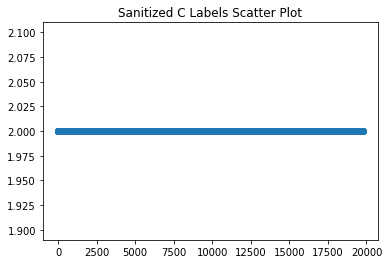

In [21]:
plt.title('Sanitized C Labels Scatter Plot')
plt.plot(np.arange(1,(len(sanitized_second_C_labels)+1)),sanitized_second_C_labels,"o")

In [22]:
#Compare three(D) classes between training and test datasets
training_index_list_D = []
duplicate_count_D = 0
start = time()
for i in range(60000,80000):
    for j in range(3000,4000):
        if (np.array_equal(train_dataset[i,0:28,0:28],test_dataset[j,0:28,0:28])):
            training_index_list_D.append(i)
            duplicate_count_D +=1
            break
            
end = time()
print('Completed in {:.4f} hours'.format((end-start)/3600.0))
print('{} Duplicate D Images'.format(duplicate_count_D))

    
    

Completed in 0.0290 hours
135 Duplicate D Images


In [23]:
"""
Delete duplicate image between training and test datasets in new sanitized class D dataset with np.delete
"""
print('D Class Training Duplication Index List',training_index_list_D)

# Define temporary  dataset and labels np arrays for image class to address np.delete max index limitation
array_size = 20000
start_splice = 60000
end_splice = 80000
temp_dataset = np.ndarray((array_size, 28, 28), dtype=np.float32)
temp_dataset = train_dataset[start_splice:end_splice,0:28,0:28]
temp_labels = np.ndarray(array_size, dtype=np.int32)
temp_labels= train_labels[start_splice:end_splice,]

# Define offset index list of image class duplicates
offset_training_index_list = []
index_offset = 60000
#Loop for index to offset
for i in range(0,len(training_index_list_D)):
    offset_training_index_list.append(training_index_list_D[i]-index_offset)
start = time()
# Create new sanitized class dataset without duplicate images
sanitized_D_dataset = np.delete(temp_dataset[0:array_size,0:28,0:28],offset_training_index_list,0)
# Create new sanitized label array
sanitized_D_labels = np.delete(temp_labels[0:array_size,],offset_training_index_list,0)
end = time()       

print('Completed in {:.4f} hours'.format((end-start)/3600.0))
print('Sanitized D Dataset:', sanitized_D_dataset.shape, sanitized_D_labels.shape)


D Class Training Duplication Index List [60043, 60115, 60132, 60191, 60508, 60695, 60698, 60825, 60940, 61171, 61461, 61708, 61769, 61846, 61848, 62333, 62620, 62821, 62830, 62873, 62875, 62936, 63192, 63247, 63427, 63518, 63519, 64021, 64392, 64512, 64652, 64656, 64914, 64938, 64952, 65262, 65351, 65358, 65489, 65662, 65750, 66019, 66093, 66108, 66415, 66477, 66740, 66906, 67161, 67204, 67386, 67496, 67497, 67574, 67695, 67792, 67860, 68058, 68482, 68758, 68967, 69023, 69079, 69080, 69235, 69349, 69537, 70036, 70108, 70264, 70320, 70523, 70661, 70715, 70753, 70954, 71193, 71260, 71267, 71333, 71843, 72029, 72159, 72208, 72312, 72453, 72618, 72733, 72874, 73099, 73373, 73675, 73681, 73848, 73892, 74289, 74888, 75060, 75081, 75341, 75704, 75752, 75819, 76639, 76642, 76790, 76828, 77043, 77185, 77244, 77404, 77508, 77803, 77909, 77966, 77967, 78042, 78206, 78280, 78302, 78537, 78639, 78710, 78747, 78798, 78813, 79218, 79261, 79520, 79537, 79752, 79835, 79865, 79869, 79892]
Completed in 0

In [24]:

#Compare three(D) classes between sanitized training and valid datasets for validation
sanitized_second_index_list_D = []
sanitized_second_duplicate_count_D = 0
array_range = sanitized_D_dataset.shape[0]
start = time()
for i in range(0,array_range):
    for j in range(3000,4000):
        if (np.array_equal(sanitized_D_dataset[i,0:28,0:28],valid_dataset[j,0:28,0:28])):
            sanitized_second_index_list_D.append(i)
            sanitized_second_duplicate_count_D +=1
            break
end = time()
print('Completed in {:.4f} hours'.format((end-start)/3600.0))
print('{} Duplicate D Images with Valid Dataset'.format(sanitized_second_duplicate_count_D))
print('Second Sanitized D Duplicate Index List',sanitized_second_index_list_D)

    
    

Completed in 0.0289 hours
126 Duplicate D Images with Valid Dataset
Second Sanitized D Duplicate Index List [152, 286, 342, 409, 437, 518, 582, 709, 713, 933, 1015, 1056, 1103, 1147, 1204, 1246, 1429, 1473, 1487, 1865, 1886, 1888, 1902, 1983, 2342, 2432, 2537, 2557, 2963, 3093, 3150, 3191, 3199, 3555, 3667, 3691, 3875, 3963, 4078, 4502, 4547, 4576, 4886, 5324, 5524, 5793, 6502, 6530, 6779, 6970, 7511, 7629, 7746, 7801, 7812, 7838, 8167, 8349, 8403, 8641, 8979, 9078, 9461, 9536, 9631, 9782, 10103, 10218, 10403, 10636, 10685, 10797, 10809, 10893, 10962, 10983, 11033, 11334, 11443, 11480, 11610, 11800, 11837, 11875, 11903, 12020, 12460, 12682, 12947, 13273, 13294, 13414, 13642, 13859, 13899, 13949, 13994, 14192, 14342, 14478, 14668, 14696, 15315, 15560, 15694, 15807, 15938, 16124, 16344, 16494, 16715, 16935, 16946, 17153, 17223, 17236, 17313, 17575, 17761, 17889, 18025, 18588, 19054, 19470, 19748, 19785]


In [25]:
"""
Delete duplicate image between the sanitized training and valid datasets in a new sanitized class D dataset with np.delete
"""
print('Second Sanitized D Duplicate Index List',sanitized_second_index_list_D)
first_dataset_size = sanitized_D_dataset.shape[0]
start = time()
# Create new sanitized class dataset without duplicate images
sanitized_second_D_dataset = np.delete(sanitized_D_dataset[0:first_dataset_size,0:28,0:28],sanitized_second_index_list_D,0)
# Create new sanitized label array
sanitized_second_D_labels = np.delete(sanitized_D_labels[0:first_dataset_size,],sanitized_second_index_list_D,0)
end = time()       

print('Completed in {:.4f} hours'.format((end-start)/3600.0))
print('Sanitized D Dataset:', sanitized_second_D_dataset.shape, sanitized_second_D_labels.shape)


Second Sanitized D Duplicate Index List [152, 286, 342, 409, 437, 518, 582, 709, 713, 933, 1015, 1056, 1103, 1147, 1204, 1246, 1429, 1473, 1487, 1865, 1886, 1888, 1902, 1983, 2342, 2432, 2537, 2557, 2963, 3093, 3150, 3191, 3199, 3555, 3667, 3691, 3875, 3963, 4078, 4502, 4547, 4576, 4886, 5324, 5524, 5793, 6502, 6530, 6779, 6970, 7511, 7629, 7746, 7801, 7812, 7838, 8167, 8349, 8403, 8641, 8979, 9078, 9461, 9536, 9631, 9782, 10103, 10218, 10403, 10636, 10685, 10797, 10809, 10893, 10962, 10983, 11033, 11334, 11443, 11480, 11610, 11800, 11837, 11875, 11903, 12020, 12460, 12682, 12947, 13273, 13294, 13414, 13642, 13859, 13899, 13949, 13994, 14192, 14342, 14478, 14668, 14696, 15315, 15560, 15694, 15807, 15938, 16124, 16344, 16494, 16715, 16935, 16946, 17153, 17223, 17236, 17313, 17575, 17761, 17889, 18025, 18588, 19054, 19470, 19748, 19785]
Completed in 0.0000 hours
Sanitized D Dataset: (19739, 28, 28) (19739,)


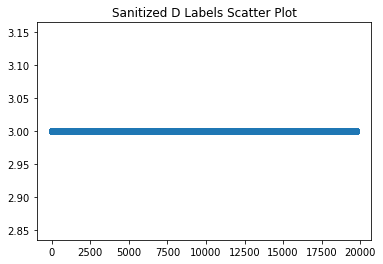

In [26]:
plt.title('Sanitized D Labels Scatter Plot')
plt.plot(np.arange(1,(len(sanitized_second_D_labels)+1)),sanitized_second_D_labels,"o")

In [27]:
#Compare four(E) classes between training and test datasets
training_index_list_E = []
duplicate_count_E = 0
start = time()
for i in range(80000,100000):
    for j in range(4000,5000):
        if (np.array_equal(train_dataset[i,0:28,0:28],test_dataset[j,0:28,0:28])):
            training_index_list_E.append(i)
            duplicate_count_E +=1
            break
end = time()
print('Completed in {:.4f} hours'.format((end-start)/3600.0))
print('{} Duplicate E Images'.format(duplicate_count_E))

    
    

Completed in 0.0290 hours
136 Duplicate E Images


In [28]:
"""
Delete duplicate image between training and test datasets in new sanitized class E dataset with np.delete
"""
print('E Class Training Duplication Index List',training_index_list_E)

# Define temporary  dataset and labels np arrays for image class to address np.delete max index limitation 

array_size = 20000
start_splice = 80000
end_splice = 100000
temp_dataset = np.ndarray((array_size, 28, 28), dtype=np.float32)
temp_dataset = train_dataset[start_splice:end_splice,0:28,0:28]
temp_labels = np.ndarray(array_size, dtype=np.int32)
temp_labels= train_labels[start_splice:end_splice,]

# Define offset index list of image class duplicates
offset_training_index_list = []
index_offset = 80000
#Loop for index to offset
for i in range(0,len(training_index_list_E)):
    offset_training_index_list.append(training_index_list_E[i]-index_offset)

start = time()
# Create new sanitized class dataset without duplicate images
sanitized_E_dataset = np.delete(temp_dataset[0:array_size,0:28,0:28],offset_training_index_list,0)
# Create new sanitized label array
sanitized_E_labels = np.delete(temp_labels[0:array_size,],offset_training_index_list,0)
end = time()       

print('Completed in {:.4f} hours'.format((end-start)/3600.0))
print('Sanitized E Dataset:', sanitized_E_dataset.shape, sanitized_E_labels.shape)


E Class Training Duplication Index List [80211, 80261, 80495, 80602, 80633, 80736, 80825, 81243, 81377, 81837, 81883, 82515, 82572, 82578, 82682, 82703, 82752, 82850, 82983, 83079, 83133, 83269, 83543, 83713, 83797, 83877, 83962, 84084, 84286, 84386, 84388, 84407, 84446, 84603, 84659, 84856, 84888, 85056, 85058, 85128, 85152, 85322, 85987, 86103, 86150, 86452, 86471, 86650, 86741, 86922, 87167, 87178, 87333, 87572, 87768, 87906, 88016, 88138, 88281, 88307, 88329, 88418, 88531, 88807, 88837, 88986, 89186, 89459, 89564, 89621, 89684, 89869, 89894, 89897, 90525, 90617, 90717, 90873, 91110, 91191, 91316, 91430, 91523, 91679, 91806, 91884, 91913, 91956, 92047, 92130, 92260, 92475, 92584, 93166, 93384, 93532, 93542, 93611, 94011, 94197, 94419, 94525, 94570, 94591, 94726, 94938, 94951, 95168, 95186, 95343, 95478, 95695, 95844, 95934, 96043, 96108, 96386, 96398, 96617, 96713, 96836, 96944, 97002, 97228, 97500, 97707, 97775, 98166, 98313, 98472, 98532, 98551, 98847, 99364, 99811, 99848]
Complet

In [29]:

#Compare four(E) classes between sanitized training and valid datasets for validation
sanitized_second_index_list_E = []
sanitized_second_duplicate_count_E = 0
array_range = sanitized_E_dataset.shape[0]
start = time()
for i in range(0,array_range):
    for j in range(4000,5000):
        if (np.array_equal(sanitized_E_dataset[i,0:28,0:28],valid_dataset[j,0:28,0:28])):
            sanitized_second_index_list_E.append(i)
            sanitized_second_duplicate_count_E +=1
            break
end = time()
print('Completed in {:.4f} hours'.format((end-start)/3600.0))
print('{} Duplicate E Images with Valid Dataset'.format(sanitized_second_duplicate_count_E))
print('Second Sanitized E Duplicate Index List',sanitized_second_index_list_E)

    
    

Completed in 0.0290 hours
103 Duplicate E Images with Valid Dataset
Second Sanitized E Duplicate Index List [545, 638, 712, 862, 979, 1019, 1272, 1287, 1298, 1333, 1335, 1343, 1404, 1975, 2462, 2522, 3109, 3301, 3481, 3674, 3696, 3742, 3783, 4216, 4229, 4591, 4600, 4604, 4943, 4980, 5234, 5300, 5509, 6811, 7028, 7077, 7251, 7405, 7438, 8237, 8324, 8372, 8480, 8676, 8783, 8793, 8925, 9017, 9205, 9434, 9460, 9545, 9840, 11202, 11287, 11420, 11518, 11569, 11657, 12254, 12815, 13107, 13683, 14027, 14362, 14445, 14502, 14632, 14635, 14869, 15195, 15221, 15248, 15332, 15339, 15547, 15710, 15999, 16007, 16152, 16228, 16296, 16338, 16350, 16406, 16512, 16623, 16960, 16981, 17030, 17265, 17921, 18026, 18063, 18099, 18113, 18119, 18245, 18290, 18963, 19025, 19656, 19816]


In [30]:
"""
Delete duplicate image between the sanitized training and valid datasets in a new sanitized class E dataset with np.delete
"""
print('Second Sanitized E Duplicate Index List',sanitized_second_index_list_E)
first_dataset_size = sanitized_E_dataset.shape[0]
start = time()
# Create new sanitized class dataset without duplicate images
sanitized_second_E_dataset = np.delete(sanitized_E_dataset[0:first_dataset_size,0:28,0:28],sanitized_second_index_list_E,0)
# Create new sanitized label array
sanitized_second_E_labels = np.delete(sanitized_E_labels[0:first_dataset_size,],sanitized_second_index_list_E,0)
end = time()       

print('Completed in {:.4f} hours'.format((end-start)/3600.0))
print('Sanitized E Dataset:', sanitized_second_E_dataset.shape, sanitized_second_E_labels.shape)


Second Sanitized E Duplicate Index List [545, 638, 712, 862, 979, 1019, 1272, 1287, 1298, 1333, 1335, 1343, 1404, 1975, 2462, 2522, 3109, 3301, 3481, 3674, 3696, 3742, 3783, 4216, 4229, 4591, 4600, 4604, 4943, 4980, 5234, 5300, 5509, 6811, 7028, 7077, 7251, 7405, 7438, 8237, 8324, 8372, 8480, 8676, 8783, 8793, 8925, 9017, 9205, 9434, 9460, 9545, 9840, 11202, 11287, 11420, 11518, 11569, 11657, 12254, 12815, 13107, 13683, 14027, 14362, 14445, 14502, 14632, 14635, 14869, 15195, 15221, 15248, 15332, 15339, 15547, 15710, 15999, 16007, 16152, 16228, 16296, 16338, 16350, 16406, 16512, 16623, 16960, 16981, 17030, 17265, 17921, 18026, 18063, 18099, 18113, 18119, 18245, 18290, 18963, 19025, 19656, 19816]
Completed in 0.0000 hours
Sanitized E Dataset: (19761, 28, 28) (19761,)


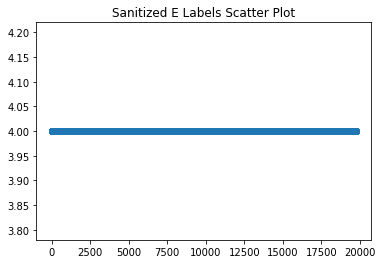

In [31]:
plt.title('Sanitized E Labels Scatter Plot')
plt.plot(np.arange(1,(len(sanitized_second_E_labels)+1)),sanitized_second_E_labels,"o")

In [32]:
#Compare five(F) classes between training and test datasets
training_index_list_F = []
duplicate_count_F = 0
start = time()
for i in range(100000,120000):
    for j in range(5000,6000):
        if (np.array_equal(train_dataset[i,0:28,0:28],test_dataset[j,0:28,0:28])):
            training_index_list_F.append(i)
            duplicate_count_F +=1
            break
end = time()
print('Completed in {:.4f} hours'.format((end-start)/3600.0))
print('{} Duplicate F Images'.format(duplicate_count_F))

    
    

Completed in 0.0291 hours
124 Duplicate F Images


In [33]:
"""
Delete duplicate image between training and test datasets in new sanitized class F dataset with np.delete
"""
print('F Class Training Duplication Index List',training_index_list_F)

# Define temporary  dataset and labels np arrays for image class to address np.delete max index limitation
array_size = 20000
start_splice = 100000
end_splice = 120000
temp_dataset = np.ndarray((array_size, 28, 28), dtype=np.float32)
temp_dataset = train_dataset[start_splice:end_splice,0:28,0:28]
temp_labels = np.ndarray(array_size, dtype=np.int32)
temp_labels= train_labels[start_splice:end_splice,]

# Define offset index list of image class duplicates
offset_training_index_list = []
index_offset = 100000
#Loop for index to offset
for i in range(0,len(training_index_list_F)):
    offset_training_index_list.append(training_index_list_F[i]-index_offset)
start = time()
# Create new sanitized class dataset without duplicate images
sanitized_F_dataset = np.delete(temp_dataset[0:array_size,0:28,0:28],offset_training_index_list,0)
# Create new sanitized label array
sanitized_F_labels = np.delete(temp_labels[0:array_size,],offset_training_index_list,0)
end = time()       

print('Completed in {:.4f} hours'.format((end-start)/3600.0))
print('Sanitized F Dataset:', sanitized_F_dataset.shape, sanitized_F_labels.shape)


F Class Training Duplication Index List [100040, 100356, 100393, 100778, 101052, 101127, 101246, 101420, 101549, 101731, 101745, 101786, 101830, 101977, 102273, 102322, 102361, 102436, 102506, 102526, 102654, 102922, 102981, 103189, 103285, 103299, 103831, 104078, 104272, 104440, 104711, 104806, 104950, 105016, 105034, 105313, 105317, 105411, 106332, 106479, 106523, 106800, 106836, 107113, 107118, 107177, 107306, 107316, 107338, 107463, 107630, 107946, 108002, 108015, 108232, 108285, 108539, 108708, 108941, 109130, 109474, 109781, 109843, 109891, 109915, 110041, 110260, 110419, 110426, 110588, 110617, 110935, 110937, 111273, 111318, 111711, 111991, 112019, 112280, 112425, 112572, 112644, 112660, 112826, 112965, 112968, 113065, 113165, 113341, 113540, 114336, 114514, 114687, 114863, 114865, 114910, 115015, 115161, 115415, 115472, 115872, 115966, 116487, 116540, 117073, 117236, 117273, 117674, 117724, 117813, 117937, 118081, 118466, 119119, 119130, 119205, 119344, 119502, 119531, 119763,

In [34]:

#Compare five(F) classes between sanitized training and valid datasets for validation
sanitized_second_index_list_F = []
sanitized_second_duplicate_count_F = 0
array_range = sanitized_F_dataset.shape[0]
start = time()
for i in range(0,array_range):
    for j in range(5000,6000):
        if (np.array_equal(sanitized_F_dataset[i,0:28,0:28],valid_dataset[j,0:28,0:28])):
            sanitized_second_index_list_F.append(i)
            sanitized_second_duplicate_count_F +=1
            break
end = time()
print('Completed in {:.4f} hours'.format((end-start)/3600.0))
print('{} Duplicate F Images with Valid Dataset'.format(sanitized_second_duplicate_count_F))
print('Second Sanitized F Duplicate Index List',sanitized_second_index_list_F)

    
    

Completed in 0.0287 hours
117 Duplicate F Images with Valid Dataset
Second Sanitized F Duplicate Index List [181, 416, 732, 954, 1428, 1770, 1831, 1861, 1871, 1992, 2099, 2296, 2480, 2542, 2652, 2980, 3170, 3557, 3732, 3795, 3990, 4006, 4025, 4150, 4218, 4687, 5342, 5770, 5957, 6361, 6457, 6641, 7026, 7531, 7734, 7964, 8140, 8408, 8482, 8540, 8776, 8792, 9157, 9518, 9607, 9721, 9908, 10303, 10432, 10462, 10573, 10593, 10866, 11284, 11305, 11394, 11583, 11612, 11739, 11987, 12180, 12210, 12239, 12248, 12458, 12460, 12859, 12943, 13057, 13100, 14086, 14123, 14169, 14431, 14494, 14588, 14967, 15108, 15212, 15239, 15273, 15310, 15340, 15758, 15774, 15829, 15990, 16055, 16210, 16257, 16356, 16461, 16843, 16873, 16894, 16974, 17085, 17141, 17366, 17439, 17466, 17630, 17818, 17895, 18111, 18443, 18542, 18634, 18798, 18878, 18975, 19469, 19493, 19525, 19564, 19608, 19850]


In [35]:
"""
Delete duplicate image between the sanitized training and valid datasets in a new sanitized class F dataset
with np.delete
"""
print('Second Sanitized F Duplicate Index List',sanitized_second_index_list_F)
first_dataset_size = sanitized_F_dataset.shape[0]
start = time()
# Create new sanitized class dataset without duplicate images
sanitized_second_F_dataset = np.delete(sanitized_F_dataset[0:first_dataset_size,0:28,0:28],\
                                       sanitized_second_index_list_F,0)
# Create new sanitized label array
sanitized_second_F_labels = np.delete(sanitized_F_labels[0:first_dataset_size,],sanitized_second_index_list_F,0)
end = time()       

print('Completed in {:.4f} hours'.format((end-start)/3600.0))
print('Sanitized F Dataset:', sanitized_second_F_dataset.shape, sanitized_second_F_labels.shape)


Second Sanitized F Duplicate Index List [181, 416, 732, 954, 1428, 1770, 1831, 1861, 1871, 1992, 2099, 2296, 2480, 2542, 2652, 2980, 3170, 3557, 3732, 3795, 3990, 4006, 4025, 4150, 4218, 4687, 5342, 5770, 5957, 6361, 6457, 6641, 7026, 7531, 7734, 7964, 8140, 8408, 8482, 8540, 8776, 8792, 9157, 9518, 9607, 9721, 9908, 10303, 10432, 10462, 10573, 10593, 10866, 11284, 11305, 11394, 11583, 11612, 11739, 11987, 12180, 12210, 12239, 12248, 12458, 12460, 12859, 12943, 13057, 13100, 14086, 14123, 14169, 14431, 14494, 14588, 14967, 15108, 15212, 15239, 15273, 15310, 15340, 15758, 15774, 15829, 15990, 16055, 16210, 16257, 16356, 16461, 16843, 16873, 16894, 16974, 17085, 17141, 17366, 17439, 17466, 17630, 17818, 17895, 18111, 18443, 18542, 18634, 18798, 18878, 18975, 19469, 19493, 19525, 19564, 19608, 19850]
Completed in 0.0000 hours
Sanitized F Dataset: (19759, 28, 28) (19759,)


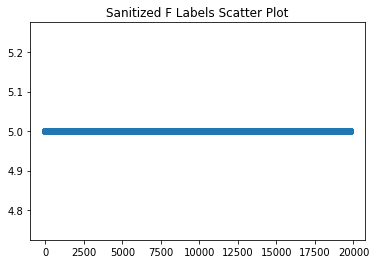

In [36]:
plt.title('Sanitized F Labels Scatter Plot')
plt.plot(np.arange(1,(len(sanitized_second_F_labels)+1)),sanitized_second_F_labels,"o")

In [37]:
#Compare six(G) classes between training and test datasets
training_index_list_G = []
duplicate_count_G = 0
start = time()
for i in range(120000,140000):
    for j in range(6000,7000):
        if (np.array_equal(train_dataset[i,0:28,0:28],test_dataset[j,0:28,0:28])):
            training_index_list_G.append(i)
            duplicate_count_G +=1
            break
end = time()
print('Completed in {:.4f} hours'.format((end-start)/3600.0))
print('{} Duplicate G Images'.format(duplicate_count_G))

    
    

Completed in 0.0292 hours
139 Duplicate G Images


144 Duplicate G Images

In [38]:
"""
Delete duplicate image between training and test datasets in new sanitized class G dataset with np.delete
"""
print('G Class Training Duplication Index List',training_index_list_G)

# Define temporary  dataset and labels np arrays for image class to address np.delete max index limitation
array_size = 20000
start_splice = 120000
end_splice = 140000
temp_dataset = np.ndarray((array_size, 28, 28), dtype=np.float32)
temp_dataset = train_dataset[start_splice:end_splice,0:28,0:28]
temp_labels = np.ndarray(array_size, dtype=np.int32)
temp_labels= train_labels[start_splice:end_splice,]

# Define offset index list of image class duplicates
offset_training_index_list = []
index_offset = 120000
#Loop for index to offset
for i in range(0,len(training_index_list_G)):
    offset_training_index_list.append(training_index_list_G[i]-index_offset)
start = time()
# Create new sanitized class dataset without duplicate images
sanitized_G_dataset = np.delete(temp_dataset[0:array_size,0:28,0:28],offset_training_index_list,0)
# Create new sanitized label array
sanitized_G_labels = np.delete(temp_labels[0:array_size,],offset_training_index_list,0)
end = time()       

print('Completed in {:.4f} hours'.format((end-start)/3600.0))
print('Sanitized G Dataset:', sanitized_G_dataset.shape, sanitized_G_labels.shape)


G Class Training Duplication Index List [120083, 120294, 120527, 120639, 120800, 120890, 120897, 121027, 121589, 121652, 122354, 122668, 122676, 122792, 122947, 123177, 123187, 123214, 123295, 123391, 123453, 123787, 123936, 123963, 124014, 124333, 124394, 124517, 124555, 124571, 124623, 124725, 125049, 125144, 125379, 125480, 125747, 125769, 125863, 125975, 126896, 127067, 127196, 127246, 127274, 127503, 127533, 127645, 127778, 127959, 128033, 128192, 128348, 128667, 128734, 128793, 128859, 129105, 129422, 129499, 129520, 129651, 129672, 129786, 129999, 130151, 130153, 130233, 130255, 130261, 130497, 130856, 131047, 131246, 131332, 131405, 131669, 131680, 131738, 131807, 131852, 132431, 132624, 132811, 132898, 133144, 133226, 133275, 133411, 133453, 133812, 133844, 133871, 133905, 133919, 134030, 134156, 134253, 134305, 134477, 134479, 134597, 134626, 134790, 134834, 135020, 135044, 135249, 135256, 135571, 135799, 135833, 136093, 136730, 136774, 136952, 137290, 137360, 137419, 137530,

In [39]:

#Compare six(G) classes between sanitized training and valid datasets for validation
sanitized_second_index_list_G = []
sanitized_second_duplicate_count_G = 0
array_range = sanitized_G_dataset.shape[0]
start = time()
for i in range(0,array_range):
    for j in range(6000,7000):
        if (np.array_equal(sanitized_G_dataset[i,0:28,0:28],valid_dataset[j,0:28,0:28])):
            sanitized_second_index_list_G.append(i)
            sanitized_second_duplicate_count_G +=1
            break
end = time()
print('Completed in {:.4f} hours'.format((end-start)/3600.0))
print('{} Duplicate G Images with Valid Dataset'.format(sanitized_second_duplicate_count_G))
print('Second Sanitized G Duplicate Index List',sanitized_second_index_list_G)

    
    

Completed in 0.0287 hours
98 Duplicate G Images with Valid Dataset
Second Sanitized G Duplicate Index List [26, 511, 592, 683, 948, 1002, 1167, 1295, 1392, 1530, 2300, 2345, 2827, 3194, 3331, 3431, 3513, 3514, 3529, 3753, 4208, 4215, 4290, 4931, 5681, 6196, 6563, 7087, 7169, 7174, 7299, 7417, 7511, 7538, 7789, 8170, 8244, 8286, 8293, 8387, 8628, 8903, 9236, 9270, 9385, 9459, 9695, 9799, 10176, 10203, 10482, 11650, 11652, 11755, 11966, 12023, 12117, 12188, 12298, 12380, 12605, 12690, 12760, 13177, 13300, 13413, 13542, 13792, 14042, 14048, 14101, 14318, 14448, 14458, 14953, 14982, 15059, 15106, 15259, 15326, 15333, 15532, 15567, 15654, 15914, 15980, 16229, 16744, 16999, 17018, 17179, 17624, 17816, 18245, 18513, 19029, 19431, 19469]


In [40]:
"""
Delete duplicate image between the sanitized training and valid datasets in a new sanitized class G dataset with np.delete
"""
print('Second Sanitized G Duplicate Index List',sanitized_second_index_list_G)
first_dataset_size = sanitized_G_dataset.shape[0]
start = time()
# Create new sanitized class dataset without duplicate images
sanitized_second_G_dataset = np.delete(sanitized_G_dataset[0:first_dataset_size,0:28,0:28],sanitized_second_index_list_G,0)
# Create new sanitized label array
sanitized_second_G_labels = np.delete(sanitized_G_labels[0:first_dataset_size,],sanitized_second_index_list_G,0)
end = time()       

print('Completed in {:.4f} hours'.format((end-start)/3600.0))
print('Sanitized G Dataset:', sanitized_second_G_dataset.shape, sanitized_second_G_labels.shape)


Second Sanitized G Duplicate Index List [26, 511, 592, 683, 948, 1002, 1167, 1295, 1392, 1530, 2300, 2345, 2827, 3194, 3331, 3431, 3513, 3514, 3529, 3753, 4208, 4215, 4290, 4931, 5681, 6196, 6563, 7087, 7169, 7174, 7299, 7417, 7511, 7538, 7789, 8170, 8244, 8286, 8293, 8387, 8628, 8903, 9236, 9270, 9385, 9459, 9695, 9799, 10176, 10203, 10482, 11650, 11652, 11755, 11966, 12023, 12117, 12188, 12298, 12380, 12605, 12690, 12760, 13177, 13300, 13413, 13542, 13792, 14042, 14048, 14101, 14318, 14448, 14458, 14953, 14982, 15059, 15106, 15259, 15326, 15333, 15532, 15567, 15654, 15914, 15980, 16229, 16744, 16999, 17018, 17179, 17624, 17816, 18245, 18513, 19029, 19431, 19469]
Completed in 0.0000 hours
Sanitized G Dataset: (19763, 28, 28) (19763,)


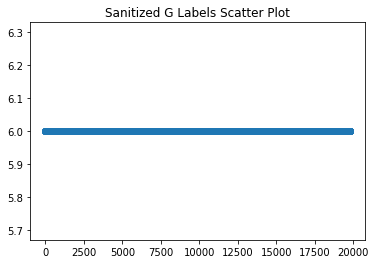

In [41]:
plt.title('Sanitized G Labels Scatter Plot')
plt.plot(np.arange(1,(len(sanitized_second_G_labels)+1)),sanitized_second_G_labels,"o")

In [42]:
#Compare seven(H) classes between training and test datasets
training_index_list_H = []
duplicate_count_H = 0
start = time()
for i in range(140000,160000):
    for j in range(7000,8000):
        if (np.array_equal(train_dataset[i,0:28,0:28],test_dataset[j,0:28,0:28])):
            training_index_list_H.append(i)
            duplicate_count_H +=1
            break
end = time()
print('Completed in {:.4f} hours'.format((end-start)/3600.0))
print('{} Duplicate H Images'.format(duplicate_count_H))

    
    

Completed in 0.0292 hours
173 Duplicate H Images


176 Duplicate H Images 

In [43]:
"""
Delete duplicate image between training and test datasets in new sanitized class H dataset with np.delete
"""
print('H Class Training Duplication Index List',training_index_list_H)

# Define temporary  dataset and labels np arrays for image class to address np.delete max index limitation
array_size = 20000
start_splice = 140000
end_splice = 160000
temp_dataset = np.ndarray((array_size, 28, 28), dtype=np.float32)
temp_dataset = train_dataset[start_splice:end_splice,0:28,0:28]
temp_labels = np.ndarray(array_size, dtype=np.int32)
temp_labels= train_labels[start_splice:end_splice,]

# Define offset index list of image class duplicates
offset_training_index_list = []
index_offset = 140000
#Loop for index to offset
for i in range(0,len(training_index_list_H)):
    offset_training_index_list.append(training_index_list_H[i]-index_offset)
start = time()
# Create new sanitized class dataset without duplicate images
sanitized_H_dataset = np.delete(temp_dataset[0:array_size,0:28,0:28],offset_training_index_list,0)
# Create new sanitized label array
sanitized_H_labels = np.delete(temp_labels[0:array_size,],offset_training_index_list,0)
end = time()       

print('Completed in {:.4f} hours'.format((end-start)/3600.0))
print('Sanitized H Dataset:', sanitized_H_dataset.shape, sanitized_H_labels.shape)


H Class Training Duplication Index List [140081, 140169, 140335, 140378, 140384, 140393, 140492, 140502, 140565, 140732, 141018, 141174, 141664, 141691, 141720, 141741, 141818, 141877, 141941, 142014, 142071, 142206, 142348, 142356, 142415, 142528, 143012, 143099, 143288, 143340, 143362, 143456, 143461, 143856, 143945, 144405, 144548, 144591, 144600, 144626, 144679, 144681, 144746, 144816, 144844, 144875, 144940, 145037, 145411, 145495, 145640, 145642, 145762, 145801, 145886, 145916, 146081, 146135, 146195, 146418, 146746, 147118, 147142, 147163, 147268, 147278, 147497, 147594, 147599, 147640, 147707, 147829, 147857, 147955, 148604, 148764, 148801, 149228, 149341, 149532, 149710, 149807, 149828, 149884, 149982, 150100, 150151, 150210, 150285, 150346, 150406, 150504, 150585, 150594, 150620, 150720, 150890, 151045, 151058, 151446, 151605, 151669, 151788, 151890, 151918, 151934, 151944, 152216, 152382, 152495, 152762, 152922, 153197, 153545, 153987, 154028, 154118, 154191, 154279, 154302,

In [45]:

#Compare seven(H) classes between sanitized training and valid datasets for validation
sanitized_second_index_list_H = []
sanitized_second_duplicate_count_H = 0
array_range = sanitized_H_dataset.shape[0]
start = time()
for i in range(0,array_range):
    for j in range(7000,8000):
        if (np.array_equal(sanitized_H_dataset[i,0:28,0:28],valid_dataset[j,0:28,0:28])):
            sanitized_second_index_list_H.append(i)
            sanitized_second_duplicate_count_H +=1
            break
end = time()
print('Completed in {:.4f} hours'.format((end-start)/3600.0))
print('{} Duplicate H Images with Valid Dataset'.format(sanitized_second_duplicate_count_H))
print('Second Sanitized H Duplicate Index List',sanitized_second_index_list_H)

    
    

Completed in 0.0287 hours
163 Duplicate H Images with Valid Dataset
Second Sanitized H Duplicate Index List [113, 187, 289, 564, 568, 593, 638, 665, 690, 708, 837, 848, 886, 889, 1300, 1500, 1672, 1737, 1798, 1912, 1947, 2275, 2277, 2452, 2655, 2849, 2936, 3152, 3196, 3373, 3485, 3590, 3689, 3723, 3843, 4105, 4184, 4239, 4392, 4453, 4601, 4629, 4630, 4718, 4934, 5206, 5385, 5387, 5529, 5582, 5698, 5752, 5857, 6689, 6783, 6823, 6938, 6971, 7136, 7164, 7268, 7347, 7384, 7447, 7506, 7528, 7777, 7801, 8126, 8165, 8210, 8329, 8382, 8439, 8626, 8641, 8901, 9249, 9250, 9422, 9594, 9616, 9718, 9815, 9949, 10403, 10413, 10560, 10563, 10588, 10687, 10892, 10972, 11176, 11381, 11406, 11768, 11832, 11868, 11987, 12023, 12236, 12434, 12481, 12754, 12755, 12760, 12970, 13040, 13338, 13560, 13579, 13707, 13803, 14141, 14261, 14281, 14578, 14631, 14769, 14789, 14923, 14933, 15101, 15130, 15170, 15183, 15347, 15371, 15380, 15554, 15638, 15673, 15755, 16025, 16111, 16168, 16284, 16427, 16640, 17060, 173

In [46]:
"""
Delete duplicate image between the sanitized training and valid datasets in a new sanitized class H dataset with np.delete
"""
print('Second Sanitized H Duplicate Index List',sanitized_second_index_list_H)
first_dataset_size = sanitized_H_dataset.shape[0]
start = time()
# Create new sanitized class dataset without duplicate images
sanitized_second_H_dataset = np.delete(sanitized_H_dataset[0:first_dataset_size,0:28,0:28],sanitized_second_index_list_H,0)
# Create new sanitized label array
sanitized_second_H_labels = np.delete(sanitized_H_labels[0:first_dataset_size,],sanitized_second_index_list_H,0)
end = time()       

print('Completed in {:.4f} hours'.format((end-start)/3600.0))
print('Sanitized H Dataset:', sanitized_second_H_dataset.shape, sanitized_second_H_labels.shape)


Second Sanitized H Duplicate Index List [113, 187, 289, 564, 568, 593, 638, 665, 690, 708, 837, 848, 886, 889, 1300, 1500, 1672, 1737, 1798, 1912, 1947, 2275, 2277, 2452, 2655, 2849, 2936, 3152, 3196, 3373, 3485, 3590, 3689, 3723, 3843, 4105, 4184, 4239, 4392, 4453, 4601, 4629, 4630, 4718, 4934, 5206, 5385, 5387, 5529, 5582, 5698, 5752, 5857, 6689, 6783, 6823, 6938, 6971, 7136, 7164, 7268, 7347, 7384, 7447, 7506, 7528, 7777, 7801, 8126, 8165, 8210, 8329, 8382, 8439, 8626, 8641, 8901, 9249, 9250, 9422, 9594, 9616, 9718, 9815, 9949, 10403, 10413, 10560, 10563, 10588, 10687, 10892, 10972, 11176, 11381, 11406, 11768, 11832, 11868, 11987, 12023, 12236, 12434, 12481, 12754, 12755, 12760, 12970, 13040, 13338, 13560, 13579, 13707, 13803, 14141, 14261, 14281, 14578, 14631, 14769, 14789, 14923, 14933, 15101, 15130, 15170, 15183, 15347, 15371, 15380, 15554, 15638, 15673, 15755, 16025, 16111, 16168, 16284, 16427, 16640, 17060, 17305, 17328, 17390, 17680, 17698, 17751, 17893, 18001, 18007, 18087, 1

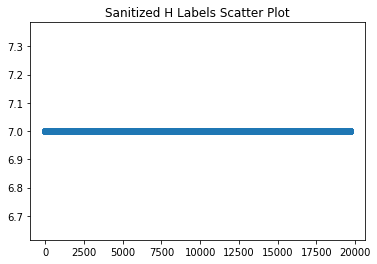

In [47]:
plt.title('Sanitized H Labels Scatter Plot')
plt.plot(np.arange(1,(len(sanitized_second_H_labels)+1)),sanitized_second_H_labels,"o")

In [48]:
#Compare eight(I) classes between training and test datasets
training_index_list_I = []
duplicate_count_I = 0
start = time()
for i in range(160000,180000):
    for j in range(8000,9000):
        if (np.array_equal(train_dataset[i,0:28,0:28],test_dataset[j,0:28,0:28])):
            training_index_list_I.append(i)
            duplicate_count_I +=1
            break
end = time()
print('Completed in {:.4f} hours'.format((end-start)/3600.0))
print('{} Duplicate I Images'.format(duplicate_count_I))

    
    

Completed in 0.0260 hours
2302 Duplicate I Images


In [49]:
"""
Delete duplicate image between training and test datasets in new sanitized class I dataset with np.delete
"""
print('I Class Training Duplication Index List',training_index_list_I)

# Define temporary  dataset and labels np arrays for image class to address np.delete max index limitation
array_size = 20000
start_splice = 160000
end_splice = 180000
temp_dataset = np.ndarray((array_size, 28, 28), dtype=np.float32)
temp_dataset = train_dataset[start_splice:end_splice,0:28,0:28]
temp_labels = np.ndarray(array_size, dtype=np.int32)
temp_labels= train_labels[start_splice:end_splice,]

# Define offset index list of image class duplicates
offset_training_index_list = []
index_offset = 160000
#Loop for index to offset
for i in range(0,len(training_index_list_I)):
    offset_training_index_list.append(training_index_list_I[i]-index_offset)
start = time()
# Create new sanitized class dataset without duplicate images
sanitized_I_dataset = np.delete(temp_dataset[0:array_size,0:28,0:28],offset_training_index_list,0)
# Create new sanitized label array
sanitized_I_labels = np.delete(temp_labels[0:array_size,],offset_training_index_list,0)
end = time()       

print('Completed in {:.4f} hours'.format((end-start)/3600.0))
print('Sanitized I Dataset:', sanitized_I_dataset.shape, sanitized_I_labels.shape)


I Class Training Duplication Index List [160001, 160024, 160031, 160037, 160075, 160102, 160107, 160110, 160116, 160122, 160132, 160141, 160151, 160156, 160174, 160190, 160201, 160211, 160215, 160216, 160229, 160230, 160239, 160248, 160249, 160251, 160258, 160273, 160280, 160293, 160308, 160323, 160325, 160328, 160338, 160343, 160346, 160353, 160365, 160366, 160367, 160371, 160379, 160382, 160401, 160402, 160403, 160419, 160427, 160430, 160449, 160465, 160467, 160490, 160510, 160548, 160565, 160570, 160583, 160587, 160595, 160597, 160600, 160626, 160637, 160656, 160662, 160676, 160725, 160728, 160729, 160741, 160750, 160751, 160752, 160760, 160771, 160781, 160785, 160802, 160805, 160807, 160812, 160834, 160836, 160840, 160856, 160862, 160883, 160884, 160887, 160888, 160894, 160896, 160922, 160923, 160927, 160952, 160968, 160973, 160975, 160988, 161013, 161037, 161048, 161055, 161061, 161068, 161082, 161098, 161099, 161102, 161106, 161115, 161119, 161135, 161163, 161184, 161202, 161221,

In [50]:

#Compare eight(I) classes between sanitized training and valid datasets for validation
sanitized_second_index_list_I = []
sanitized_second_duplicate_count_I = 0
array_range = sanitized_I_dataset.shape[0]
start = time()
for i in range(0,array_range):
    for j in range(8000,9000):
        if (np.array_equal(sanitized_I_dataset[i,0:28,0:28],valid_dataset[j,0:28,0:28])):
            sanitized_second_index_list_I.append(i)
            sanitized_second_duplicate_count_I +=1
            break
end = time()
print('Completed in {:.4f} hours'.format((end-start)/3600.0))
print('{} Duplicate I Images with Valid Dataset'.format(sanitized_second_duplicate_count_I))
print('Second Sanitized I Duplicate Index List',sanitized_second_index_list_I)

    
    

Completed in 0.0256 hours
127 Duplicate I Images with Valid Dataset
Second Sanitized I Duplicate Index List [102, 356, 382, 540, 764, 765, 830, 1025, 1299, 1377, 1382, 1695, 1707, 1952, 1976, 2067, 2096, 2365, 2443, 2454, 2533, 2674, 2758, 2924, 3075, 3449, 3458, 3488, 3707, 3816, 4449, 4555, 4755, 4831, 4952, 5403, 5420, 5448, 5573, 5666, 5902, 5967, 5988, 5992, 6279, 6294, 6487, 6695, 6900, 6918, 7117, 7566, 7639, 7651, 7825, 7903, 8394, 8466, 8472, 8658, 8738, 8799, 8949, 8953, 9109, 9166, 9800, 9929, 10105, 10276, 10710, 10755, 10840, 10920, 11196, 11313, 11319, 11507, 11620, 12044, 12148, 12348, 12477, 12671, 12713, 12721, 12845, 12952, 12969, 13025, 13384, 13422, 13489, 13666, 13672, 13733, 13748, 13796, 13816, 13867, 14003, 14117, 14389, 14391, 14410, 14496, 14697, 14880, 15050, 15088, 15094, 15180, 15346, 15647, 15687, 15703, 15730, 15830, 15834, 16222, 16417, 16447, 17125, 17146, 17292, 17365, 17417]


In [51]:
"""
Delete duplicate image between the sanitized training and valid datasets in a new sanitized class I dataset with np.delete
"""
print('Second Sanitized I Duplicate Index List',sanitized_second_index_list_I)
first_dataset_size = sanitized_I_dataset.shape[0]
start = time()
# Create new sanitized class dataset without duplicate images
sanitized_second_I_dataset = np.delete(sanitized_I_dataset[0:first_dataset_size,0:28,0:28],sanitized_second_index_list_I,0)
# Create new sanitized label array
sanitized_second_I_labels = np.delete(sanitized_I_labels[0:first_dataset_size,],sanitized_second_index_list_I,0)
end = time()       

print('Completed in {:.4f} hours'.format((end-start)/3600.0))
print('Second Sanitized I Dataset:', sanitized_second_I_dataset.shape, sanitized_second_I_labels.shape)


Second Sanitized I Duplicate Index List [102, 356, 382, 540, 764, 765, 830, 1025, 1299, 1377, 1382, 1695, 1707, 1952, 1976, 2067, 2096, 2365, 2443, 2454, 2533, 2674, 2758, 2924, 3075, 3449, 3458, 3488, 3707, 3816, 4449, 4555, 4755, 4831, 4952, 5403, 5420, 5448, 5573, 5666, 5902, 5967, 5988, 5992, 6279, 6294, 6487, 6695, 6900, 6918, 7117, 7566, 7639, 7651, 7825, 7903, 8394, 8466, 8472, 8658, 8738, 8799, 8949, 8953, 9109, 9166, 9800, 9929, 10105, 10276, 10710, 10755, 10840, 10920, 11196, 11313, 11319, 11507, 11620, 12044, 12148, 12348, 12477, 12671, 12713, 12721, 12845, 12952, 12969, 13025, 13384, 13422, 13489, 13666, 13672, 13733, 13748, 13796, 13816, 13867, 14003, 14117, 14389, 14391, 14410, 14496, 14697, 14880, 15050, 15088, 15094, 15180, 15346, 15647, 15687, 15703, 15730, 15830, 15834, 16222, 16417, 16447, 17125, 17146, 17292, 17365, 17417]
Completed in 0.0000 hours
Second Sanitized I Dataset: (17571, 28, 28) (17571,)


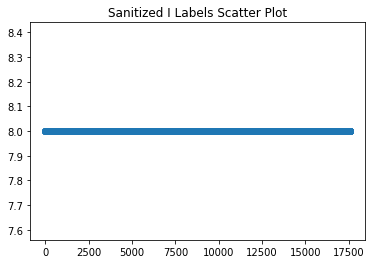

In [52]:
plt.title('Sanitized I Labels Scatter Plot')
plt.plot(np.arange(1,(len(sanitized_second_I_labels)+1)),sanitized_second_I_labels,"o")

In [53]:
#Compare nine(J) classes between training and test datasets
training_index_list_J = []
duplicate_count_J = 0
start = time()
for i in range(180000,200000):
    for j in range(9000,10000):
        if (np.array_equal(train_dataset[i,0:28,0:28],test_dataset[j,0:28,0:28])):
            training_index_list_J.append(i)
            duplicate_count_J +=1
            break
end = time()
print('Completed in {:.4f} hours'.format((end-start)/3600.0))
print('{} Duplicate J Images'.format(duplicate_count_J))

    
    

Completed in 0.0377 hours
133 Duplicate J Images


In [54]:
"""
Delete duplicate image between training and test datasets in new sanitized class J dataset with np.delete
"""
print('J Class Training Duplication Index List',training_index_list_J)

# Define temporary  dataset and labels np arrays for image class to address np.delete max index limitation
array_size = 20000
start_splice = 180000
end_splice = 200000
temp_dataset = np.ndarray((array_size, 28, 28), dtype=np.float32)
temp_dataset = train_dataset[start_splice:end_splice,0:28,0:28]
temp_labels = np.ndarray(array_size, dtype=np.int32)
temp_labels= train_labels[start_splice:end_splice,]

# Define offset index list of image class duplicates
offset_training_index_list = []
index_offset = 180000
#Loop for index to offset
for i in range(0,len(training_index_list_J)):
    offset_training_index_list.append(training_index_list_J[i]-index_offset)
    
start = time()
# Create new sanitized class dataset without duplicate images
sanitized_J_dataset = np.delete(temp_dataset[0:array_size,0:28,0:28],offset_training_index_list,0)
# Create new sanitized label array
sanitized_J_labels = np.delete(temp_labels[0:array_size,],offset_training_index_list,0)
end = time()       

print('Completed in {:.4f} hours'.format((end-start)/3600.0))
print('Sanitized J Dataset:', sanitized_J_dataset.shape, sanitized_J_labels.shape)


J Class Training Duplication Index List [180097, 180256, 180355, 180611, 180653, 180697, 180841, 180977, 181058, 181322, 182084, 182169, 182771, 182822, 182938, 183165, 183259, 183579, 183581, 183638, 183832, 183893, 183920, 184172, 184659, 185181, 185191, 185309, 185684, 185944, 186031, 186239, 186300, 186305, 186611, 186619, 186650, 187459, 187494, 187588, 187625, 187770, 188169, 188330, 188558, 188593, 188731, 188762, 188889, 189178, 189384, 189454, 189633, 189678, 189786, 189798, 189857, 189858, 190014, 190059, 190145, 190249, 190265, 190314, 190391, 190560, 190600, 190655, 190737, 190935, 191087, 191108, 191218, 191265, 191497, 191664, 191693, 191756, 191809, 192620, 192670, 192710, 192838, 192860, 192949, 192988, 193115, 193130, 193499, 193572, 193723, 194151, 194410, 194420, 194481, 194533, 194758, 194919, 194995, 195142, 195314, 195341, 195694, 195841, 196075, 196273, 196399, 196430, 196436, 196532, 196589, 196695, 196775, 196999, 197237, 197383, 197406, 197424, 197440, 197586,

In [55]:

#Compare nine(J) classes between sanitized training and valid datasets for validation
sanitized_second_index_list_J = []
sanitized_second_duplicate_count_J = 0
array_range = sanitized_J_dataset.shape[0]
start = time()
for i in range(0,array_range):
    for j in range(9000,10000):
        if (np.array_equal(sanitized_J_dataset[i,0:28,0:28],valid_dataset[j,0:28,0:28])):
            sanitized_second_index_list_J.append(i)
            sanitized_second_duplicate_count_J +=1
            break
end = time()
print('Completed in {:.4f} hours'.format((end-start)/3600.0))
print('{} Duplicate J Images with Valid Dataset'.format(sanitized_second_duplicate_count_J))
print('Second Sanitized J Duplicate Index List',sanitized_second_index_list_J)

    
    

Completed in 0.0316 hours
102 Duplicate J Images with Valid Dataset
Second Sanitized J Duplicate Index List [18, 195, 242, 273, 610, 846, 881, 1211, 1374, 1442, 1540, 1951, 2119, 2271, 2515, 2617, 2757, 2774, 3246, 3335, 3544, 3554, 3558, 3728, 3788, 3949, 4318, 4582, 4609, 4632, 4981, 5469, 5493, 6033, 6172, 6305, 6324, 7073, 7249, 7443, 7469, 7524, 8332, 8595, 8614, 8776, 8952, 9189, 9339, 9389, 9404, 9788, 9915, 10132, 10361, 10555, 10679, 10964, 11032, 11041, 11191, 11464, 11605, 11688, 11718, 11800, 11819, 12073, 12504, 12915, 13299, 13356, 13776, 13885, 13923, 14143, 14356, 14773, 14787, 14827, 15550, 15611, 15768, 16075, 16328, 16424, 16664, 16750, 16829, 17031, 17194, 17500, 17789, 17983, 17997, 18534, 18543, 18636, 19472, 19645, 19710, 19765]


In [56]:
"""
Delete duplicate image between the sanitized training and valid datasets in a new sanitized class J dataset
with np.delete
"""
print('Second Sanitized J Duplicate Index List',sanitized_second_index_list_J)
first_dataset_size = sanitized_J_dataset.shape[0]
start = time()
# Create new sanitized class dataset without duplicate images
sanitized_second_J_dataset = np.delete(sanitized_J_dataset[0:first_dataset_size,0:28,0:28],\
                                       sanitized_second_index_list_J,0)
# Create new sanitized label array
sanitized_second_J_labels = np.delete(sanitized_J_labels[0:first_dataset_size,],sanitized_second_index_list_J,0)
end = time()       

print('Completed in {:.4f} hours'.format((end-start)/3600.0))
print('Second Sanitized J Dataset:', sanitized_second_J_dataset.shape, sanitized_second_J_labels.shape)



Second Sanitized J Duplicate Index List [18, 195, 242, 273, 610, 846, 881, 1211, 1374, 1442, 1540, 1951, 2119, 2271, 2515, 2617, 2757, 2774, 3246, 3335, 3544, 3554, 3558, 3728, 3788, 3949, 4318, 4582, 4609, 4632, 4981, 5469, 5493, 6033, 6172, 6305, 6324, 7073, 7249, 7443, 7469, 7524, 8332, 8595, 8614, 8776, 8952, 9189, 9339, 9389, 9404, 9788, 9915, 10132, 10361, 10555, 10679, 10964, 11032, 11041, 11191, 11464, 11605, 11688, 11718, 11800, 11819, 12073, 12504, 12915, 13299, 13356, 13776, 13885, 13923, 14143, 14356, 14773, 14787, 14827, 15550, 15611, 15768, 16075, 16328, 16424, 16664, 16750, 16829, 17031, 17194, 17500, 17789, 17983, 17997, 18534, 18543, 18636, 19472, 19645, 19710, 19765]
Completed in 0.0000 hours
Second Sanitized J Dataset: (19765, 28, 28) (19765,)


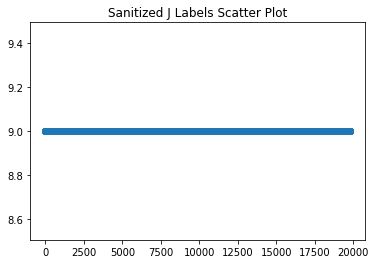

In [57]:
plt.title('Sanitized J Labels Scatter Plot')
plt.plot(np.arange(1,(len(sanitized_second_J_labels)+1)),sanitized_second_J_labels,"o")

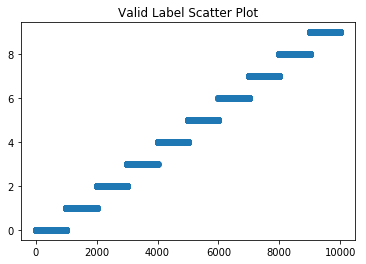

In [58]:
plt.title('Valid Label Scatter Plot')
plt.plot(np.arange(1,(len(valid_labels)+1)),valid_labels,"o")

In [59]:
"""
Combine all sanitized image classes into a single sanitized training dataset with no duplicates with the test
and validate dataset
"""

#Define list for the number of sanitized images in a  class
class_image_number_list = []

#Set number of sanitized images in each class
class_image_number_list.append(sanitized_second_A_dataset.shape[0])
class_image_number_list.append(sanitized_second_B_dataset.shape[0])
class_image_number_list.append(sanitized_second_C_dataset.shape[0])
class_image_number_list.append(sanitized_second_D_dataset.shape[0])
class_image_number_list.append(sanitized_second_E_dataset.shape[0])
class_image_number_list.append(sanitized_second_F_dataset.shape[0])
class_image_number_list.append(sanitized_second_G_dataset.shape[0])
class_image_number_list.append(sanitized_second_H_dataset.shape[0])
class_image_number_list.append(sanitized_second_I_dataset.shape[0])
class_image_number_list.append(sanitized_second_J_dataset.shape[0])

#Define list of the class dataset np array names
image_class_names = [sanitized_second_A_dataset, sanitized_second_B_dataset, sanitized_second_C_dataset,\
                    sanitized_second_D_dataset, sanitized_second_E_dataset, sanitized_second_F_dataset,\
                    sanitized_second_G_dataset,sanitized_second_H_dataset, sanitized_second_I_dataset,\
                    sanitized_second_J_dataset]

#Define list of the class labels np array names
image_label_names = [sanitized_second_A_labels, sanitized_second_B_labels, sanitized_second_C_labels,\
                    sanitized_second_D_labels, sanitized_second_E_labels, sanitized_second_F_labels,\
                    sanitized_second_G_labels, sanitized_second_H_labels, sanitized_second_I_labels,\
                    sanitized_second_J_labels]

#Compute total number of sanitized images
sanitized_total_images = sum(class_image_number_list)
print('Total number of sanitized images is',sanitized_total_images)
print('Sanitized images class number list',class_image_number_list)

#Define image dimension
img_size = 28

#Initialize np array for the sanitized dataset
sanitized_train_dataset = np.ndarray((sanitized_total_images, img_size, img_size), dtype=np.float32)
sanitized_train_labels = np.ndarray(sanitized_total_images, dtype=np.int32)

#Initialize splice start and end values
start_splice = 0
end_splice = 0

#Loop to combine sanitized images and labels into single companion datasets
for i in range(0,len(class_image_number_list)):
    end_splice = start_splice + class_image_number_list[i]
    sanitized_train_dataset[start_splice:end_splice,0:img_size,0:img_size]=image_class_names[i]
    sanitized_train_labels[start_splice:end_splice,]=image_label_names[i]
    start_splice += class_image_number_list[i]

print('Sanitized Dataset and Labels:', sanitized_train_dataset.shape, sanitized_train_labels.shape)   


Total number of sanitized images is 195307
Sanitized images class number list [19793, 19748, 19744, 19739, 19761, 19759, 19763, 19664, 17571, 19765]
Sanitized Dataset and Labels: (195307, 28, 28) (195307,)


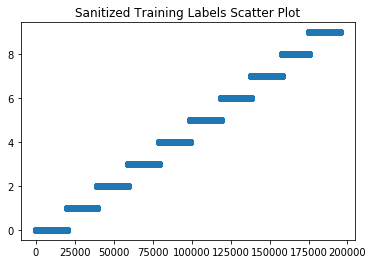

In [70]:
plt.title('Sanitized Training Labels Scatter Plot')
plt.plot(np.arange(1,(len(sanitized_train_labels)+1)),sanitized_train_labels,"o")

Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match

In [60]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)
rand_sanit_dataset,rand_sanit_labels = randomize(sanitized_train_dataset, sanitized_train_labels)

Verify dataset image labels randomly shuffled

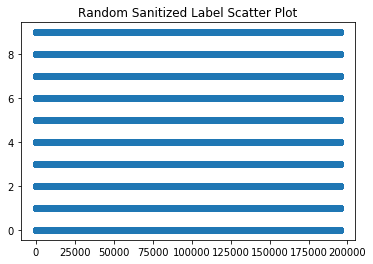

In [61]:
plt.title('Random Sanitized Label Scatter Plot')
plt.plot(np.arange(1,(len(rand_sanit_labels)+1)),rand_sanit_labels,"o")

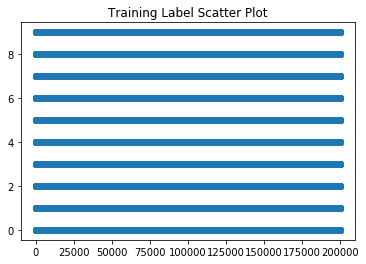

In [62]:
plt.title('Training Label Scatter Plot')
plt.plot(np.arange(1,(len(train_labels)+1)),train_labels,"o")

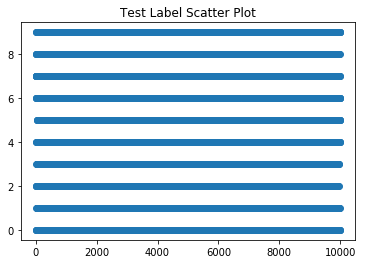

In [63]:
plt.title('Test Label Scatter Plot')
plt.plot(np.arange(1,(len(test_labels)+1)),test_labels,"o")

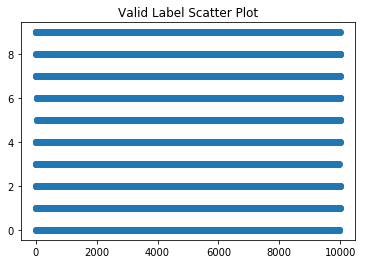

In [64]:
plt.title('Valid Label Scatter Plot')
plt.plot(np.arange(1,(len(valid_labels)+1)),valid_labels,"o")

Finally, let's save the data for later reuse:

In [ ]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    'sanitized_train_dataset':sanitized_train_dataset,
    'sanitized_train_labels':sanitized_train_labels,
    'rand_sanit_dataset':rand_sanit_dataset,
    'rand_sanit_labels':rand_sanit_labels  
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [66]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 1917328737


Problem 5
By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it. Measure how much overlap there is between training, validation and test samples.
Optional questions:
What about near duplicates between datasets? (images that are almost identical)
Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.



Problem 6
Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.
Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.
Optional question: train an off-the-shelf model on all the data!

In [3]:
# Change me to store data elsewhere
data_root = '.'
#Define pickle file path
pickle_file = os.path.join(data_root, 'notMNIST.pickle')
#Establish dictionary for saved image datasets and labels
datasets_labels_dict={}
#Open pickle file to 'rb' read instruction
pickle_datasets_file = open(pickle_file,'rb')
#Recover dictionary of  image datasets and labels nparrays
datasets_labels_dict = pickle.load(pickle_datasets_file)

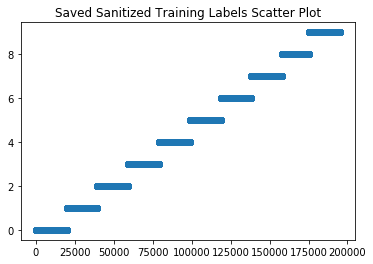

In [4]:
plt.title('Saved Sanitized Training Labels Scatter Plot')
plt.plot(np.arange(1,(len(datasets_labels_dict['sanitized_train_labels'])+1))\
         ,datasets_labels_dict['sanitized_train_labels'],"o")

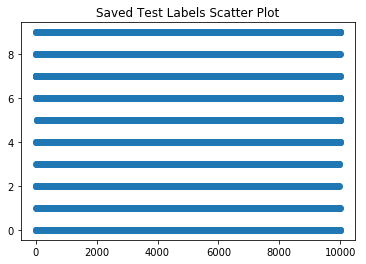

In [5]:
plt.title('Saved Test Labels Scatter Plot')
plt.plot(np.arange(1,(len(datasets_labels_dict['test_labels'])+1))\
         ,datasets_labels_dict['test_labels'],"o")